In [1]:
tr_path = 'covid.train.csv'  # path to training data
tt_path = 'covid.test.csv'   # path to testing data

In [2]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

myseed = 1  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [3]:
# 利用sklearn进行相关特征选择
import pandas as pd

# 读取训练集
data = pd.read_csv(tr_path)

# 提取特征和目标变量
features = data[data.columns[1:94]]  # 提取输入特征
target = data[data.columns[94]]       # 提取目标变量

# 特征归一化
from sklearn import preprocessing
normalized_features = (features - features.min()) / (features.max() - features.min())

# 特征选择
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

feature_selector = SelectKBest(score_func=f_regression, k=5)  # 创建特征选择器
selected_features = feature_selector.fit_transform(normalized_features, target)  # 选择特征

# 获取特征得分
feature_scores = pd.DataFrame(feature_selector.scores_)  # 获取特征得分
feature_names = pd.DataFrame(normalized_features.columns)  # 获取特征名称
feature_scores_df = pd.concat([feature_names, feature_scores], axis=1)  # 合并特征名称和得分
feature_scores_df.columns = ['Feature', 'Score']  # 设置列名

# 打印得分最高的前15个特征
print(feature_scores_df.nlargest(15, 'Score'))


               Feature          Score
75   tested_positive.1  148069.658278
57     tested_positive   69603.872591
42        hh_cmnty_cli    9235.492094
60      hh_cmnty_cli.1    9209.019558
78      hh_cmnty_cli.2    9097.375172
43      nohh_cmnty_cli    8395.421300
61    nohh_cmnty_cli.1    8343.255927
79    nohh_cmnty_cli.2    8208.176435
40                 cli    6388.906849
58               cli.1    6374.548000
76               cli.2    6250.008702
41                 ili    5998.922880
59               ili.1    5937.588576
77               ili.2    5796.947672
92  worried_finances.2     833.613191


In [4]:
class COVID19Dataset(Dataset):
    ''' 用于加载和预处理COVID19数据集 '''
    def __init__(self,
                 path,
                 mode='train',
                 target_only=False):
        """
        初始化COVID19Dataset

        参数:
            path (str): 包含数据集的CSV文件的路径。
            mode (str): 数据集的模式 - 'train'、'dev'或'test'。
            target_only (bool): 是否只考虑目标特征。
        """
        self.mode = mode

        # 读取数据到numpy数组中
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)
        
        if not target_only:
            # 如果不只考虑目标特征，则选择所有特征
            feats = list(range(93))
        else:
            # TODO: Using 40 states & 2 tested_positive features (indices = 57 & 75)
            # 选择42个特征
            # feats = list(range(40))
            # feats.append(57)
            # feats.append(75)
            feats = [75, 57, 42, 60, 78, 43, 61, 79, 40, 58, 76, 41, 59, 77] #sklearn选出的最相关特征

        if mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target = data[:, -1] #最后一列，也就是要预测的第三天的tested_positive
            data = data[:, feats]

            # 调整完成后全部数据集用来训练
            if mode == 'train':
                # indices = [i for i in range(len(data)) if i % 10 != 0]
                indices = [i for i in range(len(data))]
            elif mode == 'dev':
                # indices = [i for i in range(len(data)) if i % 10 == 0]
                indices = [i for i in range(len(data))]
            
            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # Normalize features (you may remove this part to see what will happen)
        self.data[:, 40:] = \
            (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
            / self.data[:, 40:].std(dim=0, keepdim=True)

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

In [5]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        # 增加更多层
        self.net = nn.Sequential(
            # nn.Linear(input_dim, 64),
            # nn.ReLU(),
            # nn.Linear(64,32),
            # nn.ReLU(),
            # nn.Linear(32, 1)
            
            # nn.Linear(input_dim, 32),
            # nn.BatchNorm1d(32),#使用BN
            # nn.Dropout(p=0.2),#使用Dropout
            # nn.LeakyReLU(),#更换激活函数
            # nn.Linear(32, 1)

            
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        # TODO: you may implement L2 regularization here
        regularization_loss = 0
        for param in model.parameters():
            regularization_loss += torch.sum(param ** 2)
        return self.criterion(pred, target) + 0.00075 * regularization_loss

In [6]:
def dev(dv_set, model, device):
    ''' 在验证集上计算模型损失 '''
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

In [7]:
def train(tr_set, dv_set, model, config, device):        
    """
    训练模型

    参数:
        tr_set: 训练集
        dv_set: 验证集
        model: 模型
        config: 一些初始化设置
        device: 设备
    """

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # 用于记录训练损失
    early_stop_cnt = 0 # 早停计数器
    epoch = 0 # 当前迭代次数
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # 每个迭代周期后，在验证集上测试模型
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # 保存最佳模型
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # 如果模型连续 config['early_stop'] 个迭代周期没有改进，则停止训练
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

In [8]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

设置

In [9]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
# target_only = False                   # TODO: Using 40 states & 2 tested_positive features 
target_only = True                   # 使用筛选后的特征

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 270,               # mini-batch size for dataloader
    'optimizer': 'Adam',              # 使用Adam
    # 'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        # 'lr': 0.001,                 # learning rate of SGD
        # 'momentum': 0.9              # momentum for SGD
    },
    'early_stop': 500,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}

获取数据集

In [10]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    ''' 生成数据集，然后放入dataloader. '''
    dataset = COVID19Dataset(path, mode=mode, target_only=target_only)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

In [11]:
tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only)

Finished reading the train set of COVID19 Dataset (2700 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (2700 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 14)


In [12]:
def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

训练

Saving model (epoch =    1, loss = 38.1509)
Saving model (epoch =    2, loss = 27.8404)
Saving model (epoch =    3, loss = 14.4347)
Saving model (epoch =    5, loss = 12.2779)
Saving model (epoch =    6, loss = 11.6545)
Saving model (epoch =    7, loss = 10.6928)
Saving model (epoch =    8, loss = 9.7545)
Saving model (epoch =    9, loss = 8.6968)
Saving model (epoch =   10, loss = 7.1746)
Saving model (epoch =   11, loss = 5.4599)
Saving model (epoch =   12, loss = 3.5894)
Saving model (epoch =   13, loss = 2.1972)
Saving model (epoch =   14, loss = 1.4854)
Saving model (epoch =   15, loss = 1.4129)
Saving model (epoch =   17, loss = 1.3789)
Saving model (epoch =   18, loss = 1.3609)
Saving model (epoch =   20, loss = 1.3334)
Saving model (epoch =   22, loss = 1.3215)
Saving model (epoch =   24, loss = 1.3024)
Saving model (epoch =   26, loss = 1.2992)
Saving model (epoch =   27, loss = 1.2970)
Saving model (epoch =   28, loss = 1.2814)
Saving model (epoch =   29, loss = 1.2785)
Savin

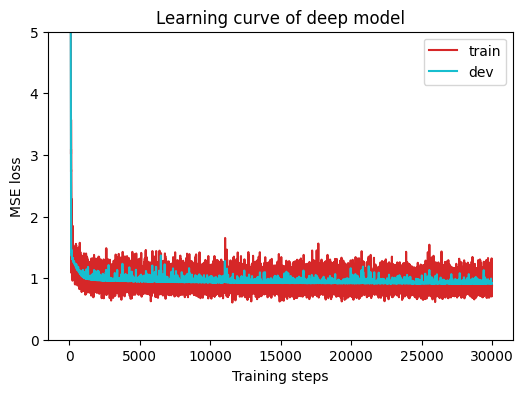

In [13]:
model = NeuralNet(tr_set.dataset.dim).to(device) 
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device) #训练模型
plot_learning_curve(model_loss_record, title='deep model') #绘制模型损失曲线

验证

In [14]:
def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

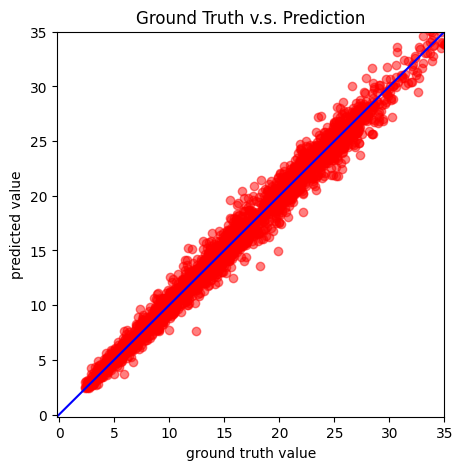

In [15]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # 加载最佳模型进行测试
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # 绘制最佳模型在验证集上的表现

测试

In [16]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

In [17]:
preds = test(tt_set, model, device)  # predict COVID-19 cases with your model

保存测试结果

In [18]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

In [19]:
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

Saving results to pred.csv
